<a href="https://colab.research.google.com/github/parkerburchett/EconCapstone/blob/main/EconCapstoneAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Determining Own-Price Elasticity for Ethereum Mining firms. 

This is an unfinished draft. 

### **Setup**

Let's setup Spark on your Colab environment.  Run the cell below!

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u275-b01-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


Link the contents of your Google Drive

In [ ]:
# autogenerated code to import my google drive

from google.colab import drive
drive.mount('/content/drive')
print('linked')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
linked


Now we authenticate a Google Drive client to download files. Please follow the instruction to enter the authoriztion code.


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
print("authenticated")

authenticated


#Import libraries.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from functools import reduce
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import DataType
from pyspark import SparkContext, SparkConf
print('imported')

imported


Initialize the Spark context.


In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context

#sc.stop()
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()
  
print('you now have a a spark session created')

you now have a a spark session created


#Load Historical Price Data, Historical Network Hashrate, and Daily New Ether. 

[Source is etherscan.io](https://etherscan.io/chart/etherprice).

I wrote EconCapstone.utils.clean_etherscan_data.py to clean the data to work nicely inside of pyspark.

I then cast the relevant columns as doubles.

In [ ]:
# load price data
price_df = spark.read.csv('/content/drive/MyDrive/data/clean_price_data.csv', header='true')
price_df = price_df.withColumn('Value',price_df['Value'].cast('double'))
price_df = price_df.withColumnRenamed('month_year', 'year_month')
price_df = price_df.withColumnRenamed('Value', 'ETH_value')


#load hashrate data
network_hashrate_df = spark.read.csv('/content/drive/MyDrive/data/clean_Network_Hash.csv', header='true')
network_hashrate_df = network_hashrate_df.withColumn('HashRate', network_hashrate_df['HashRate_(GH/s)'].cast('double'))


#load new ether data
new_ether_df = spark.read.csv('/content/drive/MyDrive/data/clean_new_ETH.csv', header='true')
new_ether_df = new_ether_df.withColumn('new_ether', new_ether_df['new_ether'].cast('double'))


price_df.show(10)
print(price_df.head)

network_hashrate_df.show(10)
print(network_hashrate_df.head)

new_ether_df.show(10)
print(new_ether_df.head)

# at some point you will need to union this in this manner
# (year_month, avg(ETH_value), sum(new_ether), average(network_hashrate))

# you only want a single entry for every year_month

+----------+---------+
|year_month|ETH_value|
+----------+---------+
|   2015-07|      0.0|
|   2015-07|      0.0|
|   2015-07|      0.0|
|   2015-08|      0.0|
|   2015-08|      0.0|
|   2015-08|      0.0|
|   2015-08|      0.0|
|   2015-08|      0.0|
|   2015-08|     2.77|
|   2015-08|     0.81|
+----------+---------+
only showing top 10 rows

<bound method DataFrame.head of DataFrame[year_month: string, ETH_value: double]>
+----------+---------------+--------+
|year_month|HashRate_(GH/s)|HashRate|
+----------+---------------+--------+
|   2015-07|        11.5297| 11.5297|
|   2015-07|        51.4594| 51.4594|
|   2015-07|        57.7845| 57.7845|
|   2015-08|        67.9224| 67.9224|
|   2015-08|        74.5737| 74.5737|
|   2015-08|        82.0352| 82.0352|
|   2015-08|        86.1558| 86.1558|
|   2015-08|        88.3326| 88.3326|
|   2015-08|        95.2981| 95.2981|
|   2015-08|       104.8971|104.8971|
+----------+---------------+--------+
only showing top 10 rows

<bound metho

#Load Ethermine Transaction Data 


In [ ]:
all_income_df =spark.read.csv('/content/drive/MyDrive/data/simplified_ethermine_data.csv', header='true')
all_income_df = all_income_df.withColumn("amount", all_income_df["amount"].cast("double"))
all_income_df.show(10)
print(all_income_df.head)

+--------------------+----------+--------+
|          to_address|year_month|  amount|
+--------------------+----------+--------+
|0x1f14c8687f345f9...|   2016-03| 1.11217|
|0x1f14c8687f345f9...|   2016-03|1.127991|
|0xa63f4afb1812b17...|   2016-03|1.437429|
|0x3d1c1b034ed3495...|   2016-03|1.933763|
|0xb202d9a6314b149...|   2016-03|1.328998|
|0x3d31a7cdbf1b995...|   2016-03|1.457546|
|0xb202d9a6314b149...|   2016-03|1.552393|
|0x1f14c8687f345f9...|   2016-03|1.977245|
|0x09d8f6b6ae4c1f1...|   2016-03|1.136996|
|0x86254a855575d05...|   2016-03| 1.03329|
+--------------------+----------+--------+
only showing top 10 rows

<bound method DataFrame.head of DataFrame[to_address: string, year_month: string, amount: double]>


See the number of elements in the Dataframe. Double check this so make sure it matche what number it ought to be.

In [ ]:
print("In total there are {} income statements from ethermine.org".format(all_income_df.count()))
print("There are {} months with data".format(all_income_df.agg(approx_count_distinct(all_income_df['year_month'])).collect()))

In total there are 30412771 income statements from ethermine.org
There are [Row(approx_count_distinct(year_month)=62)] months with data


The simplest thing is to write the queries you need in pure SQL. This only takes a few seconds to run. This method will show how much each miner made for each month. 

In [ ]:
all_income_df.registerTempTable("all_income_sql")

monthly_miner_revenue_query ="""SELECT to_address, year_month, ROUND(sum(amount),6) as monthly_revenue
FROM all_income_sql 
GROUP BY to_address, year_month
ORDER BY to_address, year_month 
"""

miner_df = spark.sql(monthly_miner_revenue_query)# this stores the total ETH produced by a miner in a month from ethermine
miner_df.show(10, False)# False will mean it won't truncate the miner addresses

+------------------------------------------+----------+---------------+
|to_address                                |year_month|monthly_revenue|
+------------------------------------------+----------+---------------+
|0x0000000000000000000000000000000000000000|2017-11   |0.015605       |
|0x0000000000000000000000000000000000000000|2017-12   |0.010762       |
|0x0000000000590a7d23c228b4a52970f5b327dbab|2018-06   |0.29666        |
|0x0000000000590a7d23c228b4a52970f5b327dbab|2018-07   |1.22561        |
|0x0000000000590a7d23c228b4a52970f5b327dbab|2018-08   |1.505965       |
|0x0000000000590a7d23c228b4a52970f5b327dbab|2018-09   |1.256921       |
|0x0000000000590a7d23c228b4a52970f5b327dbab|2018-10   |0.37134        |
|0x0000000000590a7d23c228b4a52970f5b327dbab|2018-11   |1.125465       |
|0x0000000000590a7d23c228b4a52970f5b327dbab|2018-12   |1.524211       |
|0x0000000000590a7d23c228b4a52970f5b327dbab|2019-01   |1.863654       |
+------------------------------------------+----------+---------

I double checked to see that the information was accurate for this miner: 
[0000000000590a7d23c228b4a52970f5b327dbab](https://ethermine.org/miners/0000000000590a7d23c228b4a52970f5b327dbab/payouts)

A cursory glance showed that the information matches ethermine.


#Use SQL to create dataframes for the monthly aggregate historical data

In [ ]:
price_df.registerTempTable("price_sql")
network_hashrate_df.registerTempTable("network_hashrate_sql")
new_ether_df.registerTempTable("new_ether_sql")

monthly_avg_prices_query=""" 
SELECT year_month,
ROUND(avg(ETH_value),2) as average_eth_value
FROM price_sql
GROUP BY year_month
ORDER BY year_month
"""

monthly_avg_hashrate_query = """
SELECT year_month,
ROUND(avg(HashRate),2) as average_hashrate_ghs
FROM network_hashrate_sql
GROUP BY year_month
ORDER BY year_month
"""

monthly_new_ether_query = """
SELECT year_month,
ROUND(sum(new_ether),0) as new_eth_month
FROM new_ether_sql
GROUP BY year_month
ORDER BY year_month
"""

monthly_avg_prices_df = spark.sql(monthly_avg_prices_query)
monthly_avg_hashrate_df = spark.sql(monthly_avg_hashrate_query)
monthly_new_ether_df = spark.sql(monthly_new_ether_query)

historical_data_df = monthly_avg_prices_df.join(monthly_avg_hashrate_df, on='year_month', how='left')
historical_data_df = historical_data_df.join(monthly_new_ether_df, on='year_month', how='left')

historical_data_df = historical_data_df.withColumn('ghs_required_for_one_ether_per_month', round(col('average_hashrate_ghs')/ col('new_eth_month'), 5))

# exclude the data that is 2015-07 and 2021-01 
# there is not a full month of data for these months.
historical_data_df = historical_data_df.where(col('year_month')!='2015-07') 
historical_data_df = historical_data_df.where(col('year_month')!='2021-01')

historical_data_df = historical_data_df.withColumn('USD_value_of_GHs', 
                                                   round(col('average_eth_value')/
                                                   col('ghs_required_for_one_ether_per_month'),2))

historical_data_df.orderBy("year_month", ascending=False).show()



+----------+-----------------+--------------------+-------------+------------------------------------+----------------+
|year_month|average_eth_value|average_hashrate_ghs|new_eth_month|ghs_required_for_one_ether_per_month|USD_value_of_GHs|
+----------+-----------------+--------------------+-------------+------------------------------------+----------------+
|   2020-12|           627.15|           286441.29|     419077.0|                             0.68351|          917.54|
|   2020-11|           493.42|           271793.53|     406528.0|                             0.66857|          738.02|
|   2020-10|           377.51|           261515.58|     418649.0|                             0.62467|          604.34|
|   2020-09|           363.88|           244963.52|     406391.0|                             0.60278|          603.67|
|   2020-08|            404.8|            209092.8|     422394.0|                             0.49502|          817.74|
|   2020-07|            264.8|          

# Add percent change columns to historical data

This is a very cumbersome way of calculating these values. It is correct but ugly to read. 



[Source for simple percentage change the manual way](https://www.arundhaj.com/blog/calculate-difference-with-previous-row-in-pyspark.html)
 This creates an intermediate difference column and uses that to cacluate the $ change. 
 

In [ ]:
historical_window = Window.partitionBy().orderBy("year_month")

# ADD percent_change_eth_value
################################################################################

# create a temp column that is last month's value. 
historical_data_df = historical_data_df.withColumn("prev_month_ether_value", 
                                                   lag(historical_data_df['average_eth_value']).over(historical_window))

# calculate the percent change in that column. I am rounding to 5 decimal places.
# there is no good reason for 5 decimals over 10 decimals. This just makes it more readable.
historical_data_df = historical_data_df.withColumn("percent_change_eth_value", 
                                                   round(when(isnull((historical_data_df['average_eth_value']-historical_data_df['prev_month_ether_value'])/historical_data_df['prev_month_ether_value']), 0)
                                                   .otherwise((historical_data_df['average_eth_value']-historical_data_df['prev_month_ether_value'])/historical_data_df['prev_month_ether_value'])
                                                    ,5))
# drop the temporary column
historical_data_df = historical_data_df.drop(col('prev_month_ether_value'))



# Add percent_change_ghs_required_for_one_ether_per_month column
################################################################################

# create a temp column that is last month's value. 
historical_data_df = historical_data_df.withColumn("prev_month_ghs_required", 
                                                   lag(historical_data_df['ghs_required_for_one_ether_per_month']).over(historical_window))

# calculate the percent change in that column. I am rounding to 5 decimal places.
# there is no good reason for 5 decimals over 10 decimals. This just makes it more readable.
historical_data_df = historical_data_df.withColumn("percent_change_ghs_required_for_one_ether_per_month", 
                                                   round(when(isnull((historical_data_df['ghs_required_for_one_ether_per_month']-historical_data_df['prev_month_ghs_required'])/historical_data_df['prev_month_ghs_required']), 0)
                                                   .otherwise((historical_data_df['ghs_required_for_one_ether_per_month']-historical_data_df['prev_month_ghs_required'])/historical_data_df['prev_month_ghs_required'])
                                                    ,5))
# drop the temporary column
historical_data_df = historical_data_df.drop(col('prev_month_ghs_required'))


################################################################################
# Add percent_change_USD_value_of_GHs

historical_data_df = historical_data_df.withColumn("prev_month_USD_ghs_value", 
                                                   lag(historical_data_df['USD_value_of_GHs']).over(historical_window))

# calculate the percent change in that column. I am rounding to 5 decimal places.
# there is no good reason for 5 decimals over 10 decimals. This just makes it more readable.
historical_data_df = historical_data_df.withColumn("percent_change_USD_value_of_GHs", 
                                                   round(when(isnull((historical_data_df['USD_value_of_GHs']-historical_data_df['prev_month_USD_ghs_value'])/historical_data_df['prev_month_USD_ghs_value']), 0)
                                                   .otherwise((historical_data_df['USD_value_of_GHs']-historical_data_df['prev_month_USD_ghs_value'])/historical_data_df['prev_month_USD_ghs_value'])
                                                    ,5))
# drop the temporary column
historical_data_df = historical_data_df.drop(col('prev_month_USD_ghs_value'))





################################################################################
# Methods to cleanly show the percent change in the different values
def see_change_ether_value():
  historical_data_df.select('year_month','average_eth_value',
                            'percent_change_eth_value').show()

def see_change_ghs_per_ether(): 
  historical_data_df.select('year_month','ghs_required_for_one_ether_per_month',
                            'percent_change_ghs_required_for_one_ether_per_month').show()

def see_changes_USD_value_ghs():
  historical_data_df.select('year_month','USD_value_of_GHs',
                            'percent_change_USD_value_of_GHs').show()

see_changes_USD_value_ghs()

+----------+----------------+-------------------------------+
|year_month|USD_value_of_GHs|percent_change_USD_value_of_GHs|
+----------+----------------+-------------------------------+
|   2015-08|          4000.0|                            0.0|
|   2015-09|         1901.96|                       -0.52451|
|   2015-10|         1395.83|                       -0.26611|
|   2015-11|         1483.87|                        0.06307|
|   2015-12|         1396.83|                       -0.05866|
|   2016-01|         2154.93|                        0.54273|
|   2016-02|         4607.84|                        1.13828|
|   2016-03|         7666.67|                        0.66383|
|   2016-04|         3920.35|                       -0.48865|
|   2016-05|         3948.28|                        0.00712|
|   2016-06|         3663.24|                       -0.07219|
|   2016-07|         2697.04|                       -0.26376|
|   2016-08|         2403.02|                       -0.10902|
|   2016

# Plot Absolute Historical Data

Profit Maximizing firms produce 1 thing. Average Gigahashes / Second for a month. 

In theory this is the primary thing that firms should respond to. This assumes that every firm will get convert all ETH they mine into Dollars at the average monthly price for that month. It ignores that miners might hold onto the ETH to try and sell it at a higher price in the future. 

It might be worth exploring later how true that assumption is.


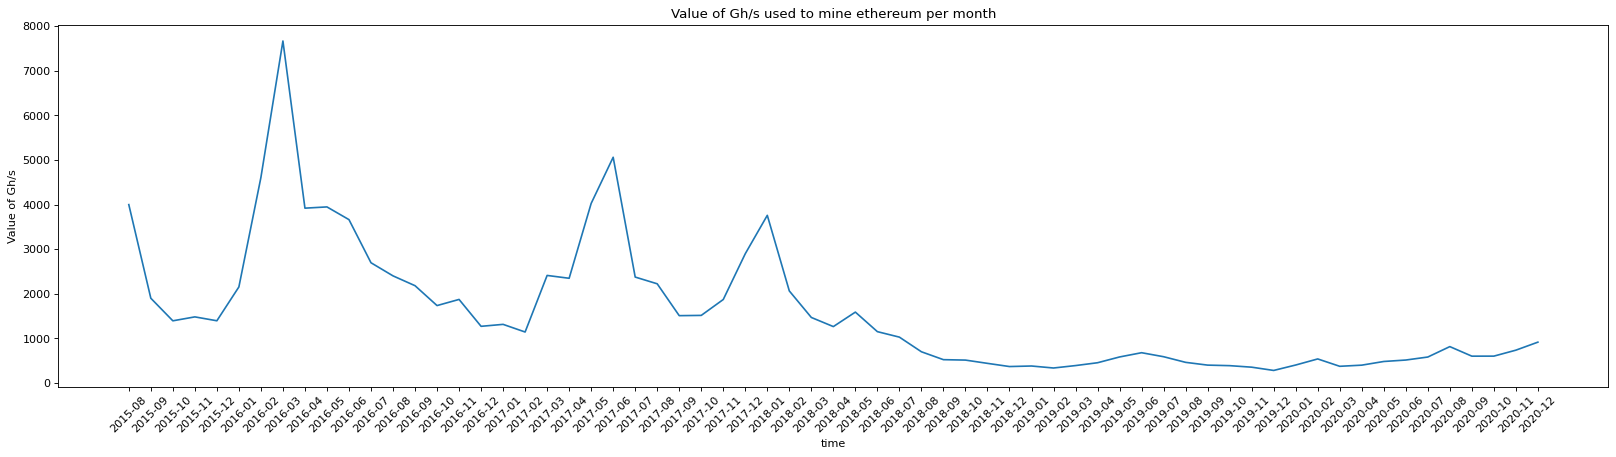

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')

historical_data_pd = historical_data_df.toPandas().sort_values('year_month')

x1 = historical_data_pd['year_month']
y1 = historical_data_pd['USD_value_of_GHs']

plt.title('Value of Gh/s used to mine ethereum per month')
plt.xticks(rotation = 45)
plt.xlabel('time')
plt.ylabel('Value of Gh/s')
plt.plot(x1,y1)
# it levels out at about 2018-08

# Plot % Change in USD value of GH/s over time


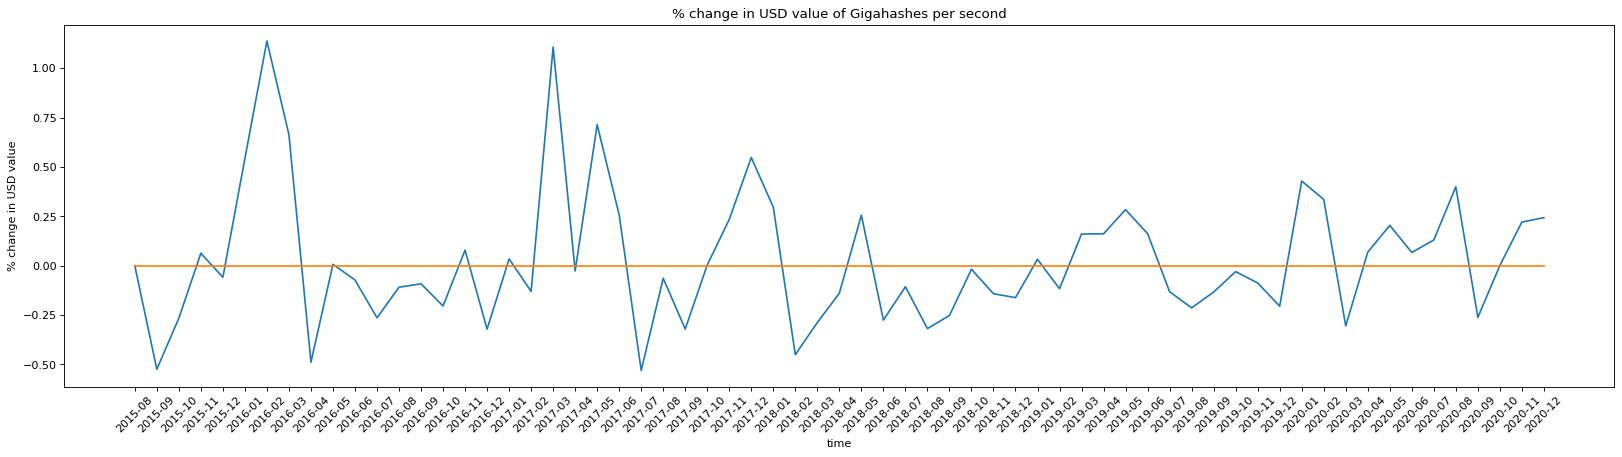

In [ ]:
figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
historical_data_pd = historical_data_df.toPandas().sort_values('year_month')

x1 = historical_data_pd['year_month']
y1 = historical_data_pd['percent_change_USD_value_of_GHs']

plt.title('% change in USD value of Gigahashes per second')
plt.xticks(rotation = 45)
plt.xlabel('time')
plt.ylabel('% change in USD value')
plt.plot(x1,y1)

y2 = [0 for x in x1] # make a list of 0 for every month. This is the baseline for comparison
plt.plot(x1,y2)

# This is what happens to your monthly revenue in USD assuming the hold their
# production constant and sell at the average monthly price every month. 

# Gigahashes needed to mine one ethereum in a month


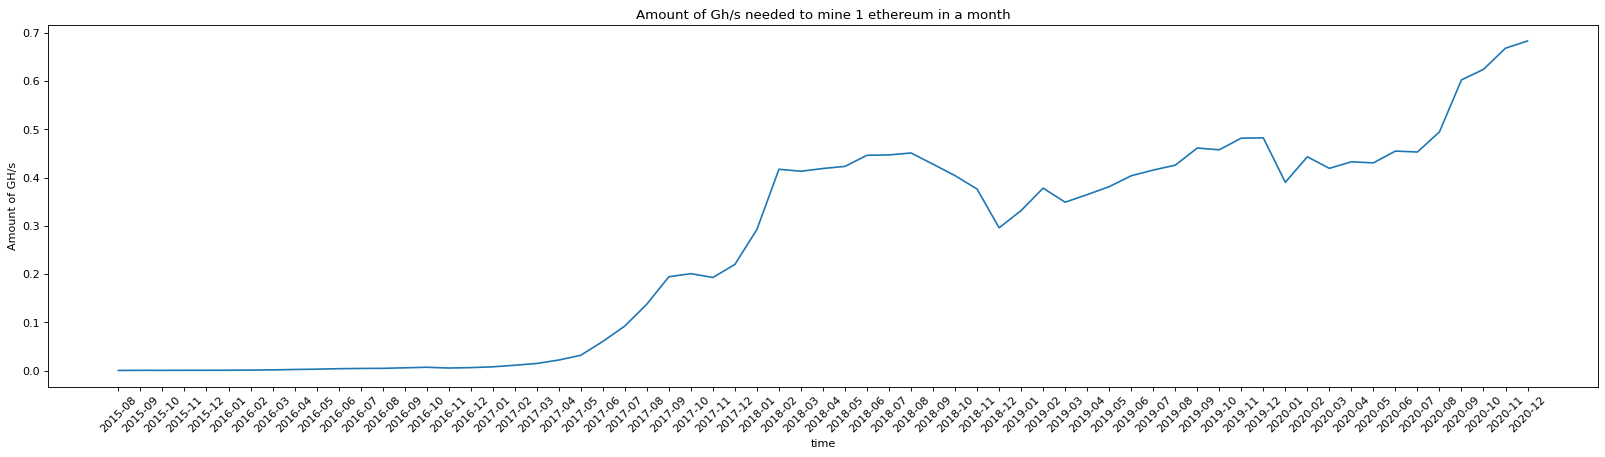

In [ ]:
x2 = historical_data_pd['year_month']
y2 = historical_data_pd['ghs_required_for_one_ether_per_month']

figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')

plt.title('Amount of Gh/s needed to mine 1 ethereum in a month')
plt.xticks(rotation = 45)

plt.xlabel('time')
plt.ylabel('Amount of GH/s')
plt.plot(x2,y2)


# Some miner's don't have any records for certain time periods. 

For some miners they could have income records for 2018-09 and 2018-11 but not for 2018-10.

This causes errors when calcuating the percentage change between months. 
  Basic logic: if Miner and no data for a month just write that as a zero. This can be done in linear time. 

To solve that I need to go through and add in the proper record for months for every miner. 

I think it will be the cleanest to download miner_df as a .csv file to Google Drive then download it onto my local computer and write the script to add in the zero months into a new csv file. That will then be uploaded that into a different notebook to do the final analysis. 




# To solve that problem I need to join the histoical data with the miner data, the download it as .csv file to my Drive. 


1.   Join Historical and Miner Dataframes
2.   Add derived Gh/s per month
2.   Remove unwanted columns
3.   Write the dataframe to my Drive


# Join Historical Data with Miner Data




In [ ]:
unified_data = miner_df.join(historical_data_df, on='year_month', how='left')
unified_data.show()

+----------+--------------------+---------------+-----------------+--------------------+-------------+------------------------------------+----------------+------------------------+---------------------------------------------------+-------------------------------+
|year_month|          to_address|monthly_revenue|average_eth_value|average_hashrate_ghs|new_eth_month|ghs_required_for_one_ether_per_month|USD_value_of_GHs|percent_change_eth_value|percent_change_ghs_required_for_one_ether_per_month|percent_change_USD_value_of_GHs|
+----------+--------------------+---------------+-----------------+--------------------+-------------+------------------------------------+----------------+------------------------+---------------------------------------------------+-------------------------------+
|   2020-06|0xc9b434958c739b3...|       0.036936|           235.29|           185950.52|     408527.0|                             0.45517|          516.93|                 0.12768|                     

# Add Dervied Average Gh/s per month. 

We have can infer how much Hash Power a firm is producing in a month with this equation:
For a month *i*
(Network_average_hashrate / new_monthly_coins) = (monthly average hashrate for Frim F / Firm F's monthly revenue).


This is simplified into 


Monthly_avg_hashrate = ((network_hashrate)*(firm_monthly_reveune)) / new coins for that month

This is measuread in Gh/s

In [ ]:
unified_data = unified_data.withColumn('derived_monthly_miner_ghs', round((unified_data['average_hashrate_ghs']
                                                                          *unified_data['monthly_revenue'])
                                                                          /unified_data['new_eth_month'],5))

unified_data.show()

+----------+--------------------+---------------+-----------------+--------------------+-------------+------------------------------------+----------------+------------------------+---------------------------------------------------+-------------------------------+-------------------------+
|year_month|          to_address|monthly_revenue|average_eth_value|average_hashrate_ghs|new_eth_month|ghs_required_for_one_ether_per_month|USD_value_of_GHs|percent_change_eth_value|percent_change_ghs_required_for_one_ether_per_month|percent_change_USD_value_of_GHs|derived_monthly_miner_ghs|
+----------+--------------------+---------------+-----------------+--------------------+-------------+------------------------------------+----------------+------------------------+---------------------------------------------------+-------------------------------+-------------------------+
|   2020-06|0xc9b434958c739b3...|       0.036936|           235.29|           185950.52|     408527.0|                      

# Remove unwanted columns

I can get percent changes later from the raw data. Since I am going to be processing on it on my local box reducing the size makes more sense. I am also going to rename the columns to what names I think are more intutitive. 

I also added a column for the miner revenue in USD assuming they sell all they make in that month at the market price. Note: This will only be right on average the time that a person sells for dollars and the amount will almost always be different that what the average price is.  



In [ ]:

to_drop = ['percent_change_in_monthly_revenue',
           'percent_change_eth_value',
           'percent_change_USD_value_of_GHs',
           'percent_change_ghs_required_for_one_ether_per_month']
cleaned_unified_df = unified_data.drop(*to_drop)


cleaned_unified_df = cleaned_unified_df.withColumnRenamed('monthly_revenue', 'miner_monthly_eth_revenue')
cleaned_unified_df = cleaned_unified_df.withColumnRenamed('average_eth_value', 'average_eth_market_price')
cleaned_unified_df = cleaned_unified_df.withColumnRenamed('average_hashrate_ghs', 'global_average_hashrate')
cleaned_unified_df = cleaned_unified_df.withColumnRenamed('new_eth_month', 'monthly_new_eth')
cleaned_unified_df = cleaned_unified_df.withColumnRenamed('USD_value_of_GHs', 'derived_USD_value_of_ghs')
cleaned_unified_df = cleaned_unified_df.withColumnRenamed('ghs_required_for_one_ether_per_month', 'derived_ghs_required_for_one_eth')
cleaned_unified_df = cleaned_unified_df.withColumn('derived_miner_monthly_USD_revenue', round(cleaned_unified_df['miner_monthly_eth_revenue']
                                                                                     *cleaned_unified_df['average_eth_market_price'],2))

cleaned_unified_df.orderBy('to_address','year_month').show()

+----------+--------------------+-------------------------+------------------------+-----------------------+---------------+--------------------------------+------------------------+-------------------------+---------------------------------+
|year_month|          to_address|miner_monthly_eth_revenue|average_eth_market_price|global_average_hashrate|monthly_new_eth|derived_ghs_required_for_one_eth|derived_USD_value_of_ghs|derived_monthly_miner_ghs|derived_miner_monthly_USD_revenue|
+----------+--------------------+-------------------------+------------------------+-----------------------+---------------+--------------------------------+------------------------+-------------------------+---------------------------------+
|   2017-11|0x000000000000000...|                 0.015605|                  361.63|              117891.11|       610712.0|                         0.19304|                 1873.34|                  0.00301|                             5.64|
|   2017-12|0x00000000000000

# get the names of columns in cleaned_unified_df


In [ ]:
cleaned_unified_df.schema.names

['year_month',
 'to_address',
 'miner_monthly_eth_revenue',
 'average_eth_market_price',
 'global_average_hashrate',
 'monthly_new_eth',
 'derived_ghs_required_for_one_eth',
 'derived_USD_value_of_ghs',
 'derived_monthly_miner_ghs',
 'derived_miner_monthly_USD_revenue']

# Write hisorical data to a csv file
This is the constants for every month

In [ ]:
historical_data_df.toPandas().to_csv('/content/drive/MyDrive/data/historical_data.csv', index=False)
# untested               
                    

# List of the unique miners 


In [ ]:
cleaned_unified_df.registerTempTable("cleaned_unified_sql")
# get a list of all the unique miners
get_unique_miners_query=""" 
SELECT DISTINCT to_address
FROM cleaned_unified_sql
ORDER BY to_address
"""

ordered_unique_miners= spark.sql(get_unique_miners_query)
# unique miners is a list of to_addresses
unique_miners = ordered_unique_miners.toPandas().values.tolist()

print(len(unique_miners)) #593674  Approx 600K miners 

593674


# Helper method to get a list of SQL between a range of addresses.
You can very the N depending on how long it will take. You want to make an error in the diriction of a N that is too large. When N =6000 you only need to make approx a thousand calls. Need error checking to not break on the last call. 

In [ ]:

# pass this the list of unique_miners and the indexes you want to get the miners between. 
# I think
#O(1) because unique_miners is just an arry in memory
def create_sql_command_for_miner_records(unique_miners, 
                                         server_name, 
                                         start_miner_index, 
                                         end_miner_index):
  start_miner = unique_miners[start_miner_index][0]
  end_miner = unique_miners[end_miner_index][0]
  
  command = """SELECT * from {}
  WHERE 
  to_address >= '{}'
  AND
  to_address <= '{}'
  ORDER BY to_address, year_month
  """.format(server_name, start_miner,end_miner)

  return command


#ans = create_sql_command_for_miner_records(unique_miners,'cleaned_unified_sql', 100, 200)
#print(ans)

# Write the dataframe to my Google Drive

# attempt 2


In [ ]:
cleaned_unified_df.sort(col("to_address"),col("year_month")).write.csv('/content/drive/MyDrive/data/crc_files',mode='overwrite')


# this works. It only takes a few seconds. 

In [ ]:
# there are ~4.3 million rows in cleaned_unified_df
# it is too large to just use the to_csv(file Path). You need to write in batches


# this works for writing the first 420k rows. I just need to wrap it in a for loop to write out the other parts. 

batch_size = int(len(unique_miners)/50)

start = 0
end = batch_size


# inital call where you write the header

counter=1

get_everything = """SELECT * FROM cleaned_unified_sql ORDER BY to_address,year_month;"""

command = create_sql_command_for_miner_records(unique_miners,
                                               'cleaned_unified_sql',
                                               start_miner_index=start,
                                               end_miner_index=len(unique_miners)-1)

first_batch = spark.sql(get_everything)

first_batch.write.json(path='/content/drive/MyDrive/data/cleaned_unified_data_json')

start=end
end=end +batch_size

stop = input('press any button to continue')

while (end + batch_size < len(unique_miners)):
  command = create_sql_command_for_miner_records(unique_miners,
                                                 'cleaned_unified_sql',
                                                 start_miner_index=start,
                                                 end_miner_index=end)

  Batch = spark.sql(command)
  Batch.write.csv(path='/content/drive/MyDrive/data/cleaned_unified_data.csv', mode='append')
  start=end
  end=end +batch_size
  counter = counter+1
  print('you wrote {} of 50'.format(counter))
  


# at this point you need to just add the last bit of the cleaned_unified_sql

command_last_chunk = create_sql_command_for_miner_records(unique_miners,
                                                          'cleaned_unified_sql',
                                                          start_miner_index=end,
                                                          end_miner_index=len(unique_miners))

last_batch = spark.sql(command_last_chunk)
last_batch.write.csv(path='/content/drive/MyDrive/data/cleaned_unified_data.csv', mode='append')
                
print('you just finished writing!')

KeyboardInterrupt: ignored

# How to determine the own-price elasticity of supply

The formula is % change in Q / % change in Price.

To get the elasticity score you need at least 2 points.

If Firm M has revenue for 40 months. They will have 39 elasticity scores. 

Simplified example to illustrate. 

Frim M has the following income statements:

(m1,m1,m3,m4)

(2018-1, 1),(2018-2, .8) (2018-3, 2) (2018-4, 1.5)

The average monthly price data for those 4 months is: 
(2018-1, 100),(2018-2, 120) (2018-3, 200) (2018-4, 130)

Between 2018-1 and 2018-2 you get this formula

(-.2/1) = % change in supply  

(20/100) = % change in price. 

to get Elasticity  = % change in supply /% change in price. 

This reduces  to -20% / 20% = -1




#It might make more sense to do this outside in pycharm. 


I think I can write some clever map reduce functions to solve this
I don't have a clear idea of what that would look like yet. 


It might make more sense to just write sorted by miner_address and year_month. all the data by file. then iterate through it. 

End up with a Miner_address, Responsiveness score. I think this is  normalized between -1 and 1. Need to verify


#Notes from meeting with 'German' (pronounced 'Hermon')
unified_data.orderBy('to_address').show(50,False)
 make sure that the same month does have the same frim twice. 
left hand side is cont.
 (FRIM, its responsivness to'% change in USD value of Gigahashes per second', firm cateogies )
 ols linear regression model. **USE That model to start with**
 left hand side score for responsiveness (percent change in total revenue) ()

 on average this is the corrilation between xi and the left hand side is +.3. he average correlation 